# CSE 7324 Lab Assignment Four: Evaluation and Multi-Layer Perceptron
Minging Li, Jiayin Liu, Tianlei Xu, He Zhou  
  Mar.25, 2018

# 1. Preparation and Overview

## 1.1 Business Understanding

The data used in this assignment represents a random sample of abalone from the Tasmanian Coastline, which was from a study initiated by the Tasmanian Aquaculture and Fisheries Institute. The goal of the study was to investigate the growth patterns of abalone living along the Tasmanian coastline. We obtained the dataset through UCI Machine Learning Repository (1). 

The classification task is to predict the rings (an indicator of age, rings + 1.5 gives the age in years) of abalone from various physical measurements. In this study, rings are treated as a 3-category classification problem (grouping rings classes 1-8, 9-12, and 13 on). Rings numbered 1-8 usually represent to infant abalone. Traditionally, the age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope, which is a boring and time-consuming task. If other measurements, such as weight, height and length, which are easier to obtain, can be used to predict the age, the estimation of abalone ages would be a much easier task. Additional, the harvest of abalone is restricted by both the number and size limit of abalone that can be caught. The restriction is an effective way to control the population of abalone. An accurate model could provide a simple way to tell the age of abalone based on their various measurements. This would be helpful for Tasmanian officials to develop rules on the size of abalone harvest. 

## 1.2 Data Understanding and Pre-processing

First, we import the dataset into Python.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel('/Users/jiayinliu/Desktop/study/ML/proj3/Abalone.xlsx')
df1 = df.copy()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


The dataset contains 9 variables and 4177 instances. The variable Sex is catagorical and other variables are numerical. 

We need to check if there are missing values.

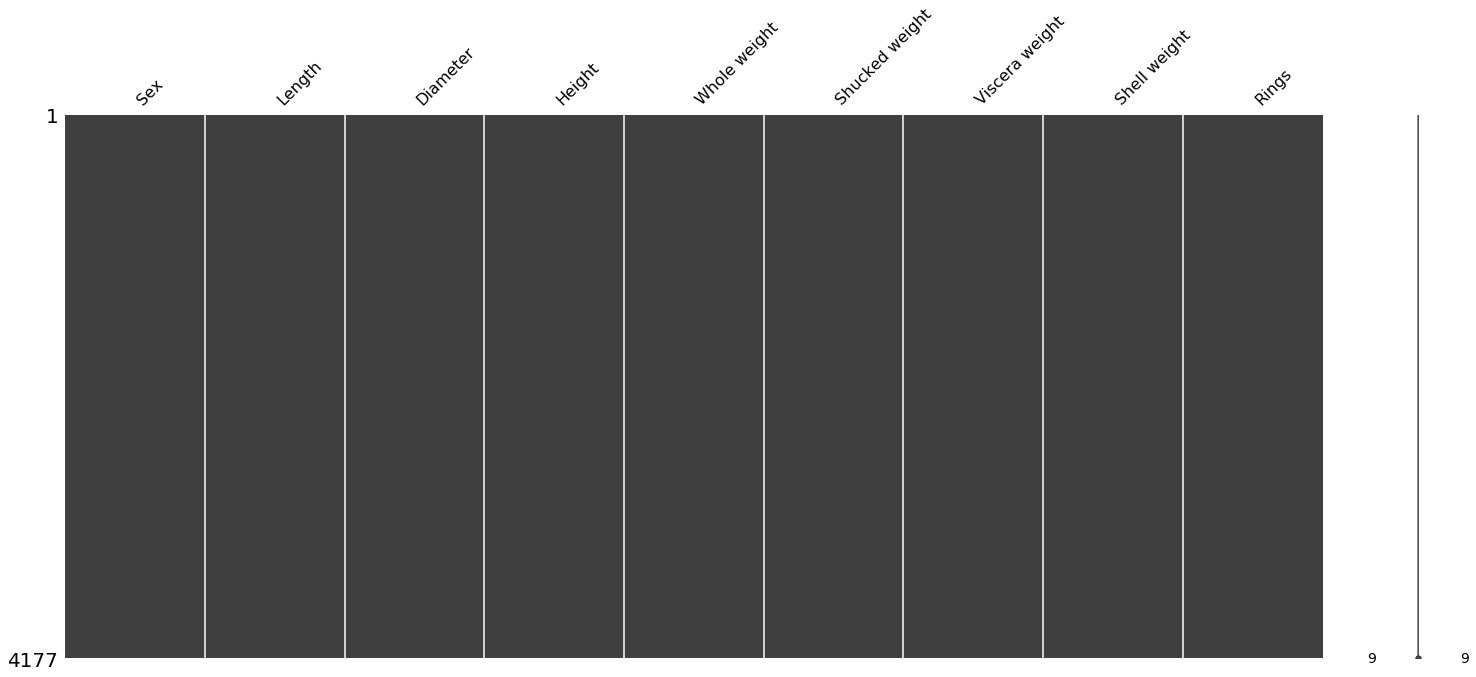

In [2]:
import missingno as mn
import matplotlib.pyplot as plt
mn.matrix(df.sort_values(by=["Rings"]))
plt.show()

We can see from the graph that there are no missing values.

We investigate the correlations among these variables.

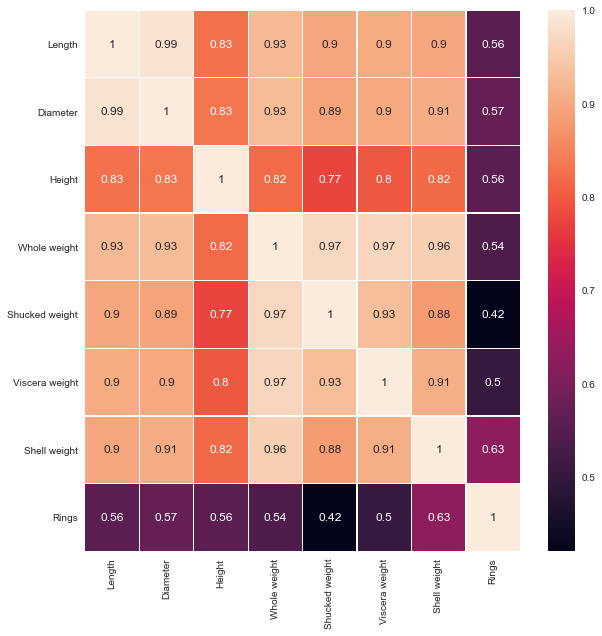

In [3]:
# show the relationship between attributes 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
graph, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), annot=True,linewidths=0.3)
graph.tight_layout()
plt.show()

The above heatmap shows the correlation coefficient between each of the numerical variables. We can see that the correlation coefficient between all other attributes except "Shucked weight" and "Rings" are higher than 0.5. "Shucked weight" and "Rings" have the lowest correlation coefficient of 0.42. To be conservative on our prection model, we keep all the 7 variables as predictors. 

We also want to investigate the relationship between the categorical variable "Sex" and "Rings".

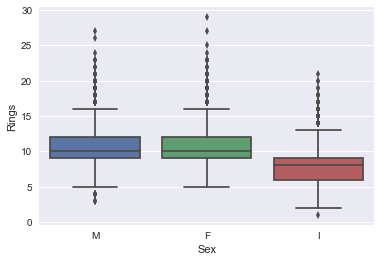

In [4]:
ax=sns.boxplot(x="Sex", y="Rings", data=df)
plt.show()

We create boxplots of "Rings" as a function of "Sex". The distributions of infant differ from the distribution of male and female. However, the distributions of male and female are almost the same. Sex is not directly related to number of rings. Thus we decide to delete the variable "Sex" to improve prediction accuracy. 

In [5]:
del df['Sex']

We treat "Rings" as a 3-category classification problem (grouping rings classes 1-8, 9-12, and 13 on). Rings numbered 1-8 usually represent to infant abalone.

In [6]:
df['Rings'] = pd.cut(df['Rings'],[0,8,12,1e6],
                                 labels=['1-8','9-12','13+']) # this creates a new variable
df.Rings.value_counts()

9-12    2077
1-8     1407
13+      693
Name: Rings, dtype: int64

Based on their rings(rings reprensent their ages),we want to classify the Abalone to three categories:Infant, youth, and adult. We use 0,1,2 to represent the classfication, 0 means infant, 1 means youth, 2 means adult.

In [7]:
df.Rings.replace(to_replace = ['1-8','9-12', '13+'],
                 value = range(3), inplace = True)

#### New Dataset Description

The new dataset contains 1 responsible variable "Rings". The type of "Rings" is nominal and the values are 0, 1, 2. The 7 explanatory variables are "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", and "Shell weight", the range of which are 0.075-0.815mm, 0.055-0.65mm, 0-1.13mm, 0.002-2.825g, 0.001-1.488g, 0.005-0.76g, and 0.0015-1.005g, respectively. All of the explanatory variables are numerical. The final dataset contains 4177 instances. 

#### Dimensionality Reduction

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
if 'Rings' in df:
    y=df['Rings'].values
    del df['Rings']
    X = df.values
cv_outerloop = StratifiedShuffleSplit(n_splits=1, test_size  = 0.2, random_state = 11)
cv_outerloop.get_n_splits(X, y)

for train_index, test_index in cv_outerloop.split(X, y):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
print('The shape of X_train:',X_train.shape)
print('The shape of X_test:',X_test.shape)
print('The shape of X:',X.shape)

The shape of X_train: (3341, 7)
The shape of X_test: (836, 7)
The shape of X: (4177, 7)


In [9]:
# dimensionality reduction
from sklearn.svm import LinearSVC
from sklearn.decomposition import RandomizedPCA

n_components = 4
pca = RandomizedPCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
clf = LinearSVC()
clf.fit(X_train,y_train)
clf.fit(X_test,y_test)

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# 2. Evaluation 

## 2.1 Evaluation Metric

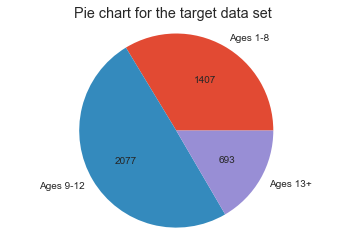

Number of instances in the classification problem: 4177


In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# plot a pie chart of classes
labels = "Ages 1-8", "Ages 9-12", "Ages 13+"
sizes = [sum(y == 0), sum(y == 1), sum(y == 2)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(df1.Rings) / 100))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart for the target data set ')
plt.show()

print('Number of instances in the classification problem:', len(df1.Rings))

From the chart we can see that, the target's class sizes are not balanced. But the way to divide is based on the related knowledge to distinguish the abalone. It is hard to change the data division, so here, we may use another evalution metric instead of accuracy. We care more about whether the algorithm correctly classfied a particular class. After checking different metrics, we decide to use F1 score, which is an average evaluation of the precision and the recall. 

F1 score has two methods, Micro-average method and Macro-average method. In Micro-average method, we sum up the individual true positives,false positives, and false negatives of the system for different sets and the apply them to get the statistics; In Macro-average method, we take the average of the F1 score of the system on different sets.

Macro-average method which weights all classes equally can be used when we want to know how the system performs overall across tne sets of data. While, micro-average method, which weights all instances equally, can be a useful measure when your dataset varies in size. ** So, here, we use micro-average F1 score as oue evaluation scorer.

In [11]:
from sklearn.metrics import make_scorer,f1_score

# make f1 micro our scorer
scorer = make_scorer(f1_score, average='micro', pos_label=1, greater_is_better = True)

## 2.2 Data Splitting

Here we created a train set and a test set by stratifiedly splitting the data. The spilt code is on the above. Then we will tune the hyper-parameters by using cross validation in train set, and then evaluate the performance of the tuned model on our test set, which generates the validation score besides the traing score. The validation score provides the performance of the model on external data, therefore it is useful information free from data snooping.

In [12]:
print('The shape of X_train:',X_train.shape)
print('The shape of X_test:',X_test.shape)
print('The shape of y_test:',y_test.shape)
print('The shape of y_test:',y_train.shape)

The shape of X_train: (3341, 4)
The shape of X_test: (836, 4)
The shape of y_test: (836,)
The shape of y_test: (3341,)


# 3. Modeling

## 3.1 Multi-layer perceptron

We create a custom implementation of the multi-layer perceptron (MLP) algorithm. In the model, the customized layers is realized, the phi function for the initial layer is selectable, either sigmoid or linear, and the cost function when instantiated is also selectable, either quadratic or cross entropy. 

In [13]:
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.special import expit
import sys
import pandas as pd
class MLPLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,           # n is nodes, not layers, still 2 layers
                 C=0.0, epochs=500, eta=0.001, random_state=None, layer = 2, phi = 'sigmoid', f_cost = 'quadratic'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.layer = layer
        self.phi = phi
        self.f_cost = f_cost
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):                                      # increase if use multi-layers
        """Initialize weights with small random numbers."""
        W = [None] * self.layer
        
        W_first_num_elems = (self.n_features_ + 1)*self.n_hidden
        W[0] = np.random.uniform(-1.0, 1.0, size = W_first_num_elems)
        W[0] = W[0].reshape(self.n_hidden, self.n_features_ + 1)
        
        W_last_num_elems = (self.n_hidden + 1)*self.n_output_
        W[self.layer - 1] = np.random.uniform(-1.0, 1.0, size = W_last_num_elems)
        W[self.layer - 1] = W[self.layer - 1].reshape(self.n_output_, self.n_hidden + 1)
        for i in range(1, self.layer - 1):
            W[i] = np.random.uniform(-1.0, 1.0, size=(self.n_hidden + 1)*self.n_hidden)
            W[i] = W[i].reshape(self.n_hidden, self.n_hidden + 1)
            
            
        return W
    
    @staticmethod
    def _sigmoid(z):    # change to linear
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)        # change here
    
    def _linear(z):
        return z
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):                                          # increase if use multi-layers
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        result = (lambda_/2.0) * np.sqrt(np.mean(W[0][:, 1:] ** 2))
        for i in range(1, len(W)):
            result = result + np.sqrt(np.mean(W[i][:, 1:] ** 2))
        return result
            
        #return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A_list,Y_enc,W):                                       # increase if use multi-layers
        '''Get the objective function value'''
        if self.f_cost == 'quadratic':
            cost = np.mean((Y_enc-A_list[-1]**2))
        elif self.f_cost == 'cross_entropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_list[-1])+(1-Y_enc)*np.log(1-A_list[-1]))))
        L2_term = self._L2_reg(self.l2_C, W)        ################################!!!!!!!!!!!!
        return cost + L2_term                   ######################!!!!!!!!!!!!!!!!!1
        #return cost
                                      
    def _feedforward(self, X, W):
        """Compute feedforward step
        """
        A_list = [None] * (len(W) + 1)
        Z_list = [None] * len(W) 
        A = self._add_bias_unit(X, how='column')
        Z = W[0] @ A.T
        
        A_list[0] = A
        Z_list[0] = Z
        
        if self.phi == 'sigmoid':
            for i in range(1, len(W)):
                A_list[i] = self._sigmoid(Z_list[i - 1])
                A_list[i] = self._add_bias_unit(A_list[i], how='row')
                Z_list[i] = W[i] @ A_list[i]

            A_list[len(W)] = self._sigmoid(Z_list[len(W) - 1])                # elements of A is 1 more than W
        
        elif self.phi == 'linear':  #######################!!!!!!!!!!!!!!!!!!
            for i in range(1, len(W)):
                #A_list[i] = self._linear(Z_list[i - 1])
                A_list[i] = Z_list[i - 1]
                A_list[i] = self._add_bias_unit(A_list[i], how='row')
                Z_list[i] = W[i] @ A_list[i]

            #A_list[len(W)] = self._linear(Z_list[len(W) - 1])
            A_list[len(W)] = Z_list[len(W) - 1]
            
        return A_list, Z_list
        
    def _get_gradient(self, A_list, Z_list, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        sigma = [None] * len(W)
        if self.f_cost == 'quadratic':
            sigma[-1] = -2 * (Y_enc - A_list[-1]) * (A_list[-1]) * (1 - A_list[-1])
        elif self.f_cost == 'cross_entropy':
            sigma[-1] = (Y_enc - A_list[-1])
        if self.phi == 'sigmoid':
            sigma[-2] = (W[-1].T @ sigma[-1]) * A_list[-2] * (1 - A_list[-2])
            for i in range(len(sigma) - 3, -1, -1):
                sigma[i] = (W[i + 1].T @ sigma[i + 1][1:,:]) * A_list[i + 1] * (1 - A_list[i + 1])
        
        elif self.phi == 'linear':
            sigma[-2] = (W[-1].T @ sigma[-1])
            for i in range(len(sigma) - 3, -1, -1):
                sigma[i] = (W[i + 1].T @ sigma[i + 1][1:,:])

        #sigma[0] = (W[1].T @ sigma[1][1:, :]) * A_list[1] * (1- A_list[1])
        #sigma[1] = (W[1].T @ sigma[2][1:, :]) * A_list[2] * (1- A_list[2])
        #sigma[0] = (W[1].T @ sigma[1][1:, :]) * A_list[1] * (1- A_list[1]) ############################
        grad_list = [None] * (self.layer)         # Number of grad <1 
        grad_list[0] = sigma[0][1:,:] @ A_list[0]
        grad_list[len(grad_list) - 1] = sigma[len(grad_list) - 1] @ A_list[len(grad_list) - 1].T
        for i in range(1, len(grad_list) - 1):
            grad_list[i] = sigma[i][1:, :] @ A_list[i].T
        for i in range(len(grad_list)):             #######################!!!!!!!!!!!!!!!!!!!!!
            grad_list[i][:, 1:] = W[i][:,1:] * self.l2_C
        return grad_list
        
    
    def predict(self, X):
        """Predict class labels"""
        A_list,Z_list = self._feedforward(X, self.W)
        y_pred = np.argmax(A_list[-1], axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.W = []
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A_list,Z_list = self._feedforward(X_data,self.W)
            
            cost = self._cost(A_list,Y_enc,self.W)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad_list = self._get_gradient(A_list, Z_list, Y_enc, self.W)

            self.W[0] -= self.eta * grad_list[0]
            self.W[len(self.W) - 1] -= self.eta * grad_list[len(self.W) - 1]
            for i in range(len(self.W)):
                self.W[i] -= self.eta * grad_list[i]
            self.score_.append(f1_score(y_data,self.predict(X_data),average='micro'))   
        return self

## 3.2 Data training

### 3.2.1 Hyper-Parameters Tuning

We tune the hyper-parameters of our MLP model. Our hyper-parameters includes phi function, objective function, and number of layers. We use different hyperparameter settings which will result in different models. Then we evaluae their respective performances in order to rank them against each other. 

#### 3.2.1.1 Phi function

We use two different hyperparameter settings for phi function, linear and sigmoid. 

In [14]:
params1 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 2, phi = 'linear', f_cost = 'quadratic')
params2 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 2, phi = 'sigmoid', f_cost = 'quadratic')

In [15]:
%%time
params1['epochs'] = 20
params2['epochs'] = 20
nn_linear = MLPLayerPerceptronBase(**params1)
nn_sigmoid = MLPLayerPerceptronBase(**params2)
nn_linear.fit(X_train, y_train, print_progress=50)
nn_sigmoid.fit(X_train, y_train, print_progress=50)

CPU times: user 449 ms, sys: 57.5 ms, total: 507 ms
Wall time: 266 ms


As mentioned in Section 2, we use micro-average f1 score to evaluate the performance of different models. We plot graphs to visualize the evaluation metric(s) versus the hyper-parameters.

In [16]:
def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',f1_score(y_train,yhat,average='micro'))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',f1_score(y_test,yhat,average='micro'))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')

    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Linear :
Resubstitution acc: 0.337024842861
Validation acc: 0.336124401914
Sigmoid :
Resubstitution acc: 0.495959293625
Validation acc: 0.494019138756


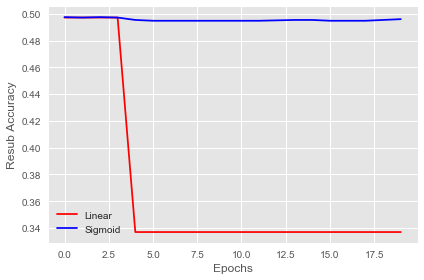

In [17]:
print_result(nn_linear,X_train,y_train,X_test,y_test,title="Linear",color="red")
print_result(nn_sigmoid,X_train,y_train,X_test,y_test,title="Sigmoid",color="blue")

plt.show()

From the plot of resubstitution accuracy versus the training iteration, the resubstitution accuracy for Sigmoid phi function is around 0.50 and that for Linear phi function is 0.50 at the beginning, but decreases to 0.34 after the 4 iterations. The phi function of Sigmoid shows a better resubstitution accuracy. 

#### 3.2.1.2 Objective function

We use sigmoid as our phi function and set cost function to two different settings, cross entropy and quadratic.

In [18]:
params3 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 2, phi = 'sigmoid', f_cost = 'cross_entropy')
params4 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 2, phi = 'sigmoid', f_cost = 'quadratic')

In [19]:
%%time
params3['epochs'] = 1000
params4['epochs'] = 1000
nn_cross_entropy = MLPLayerPerceptronBase(**params3)
nn_quadratic = MLPLayerPerceptronBase(**params4)
nn_cross_entropy.fit(X_train, y_train, print_progress=50)
nn_quadratic.fit(X_train, y_train, print_progress=50)

Epoch: 1000/1000

CPU times: user 25.1 s, sys: 1.39 s, total: 26.5 s
Wall time: 13.5 s


Cross Entropy Loss :
Resubstitution acc: 0.337024842861
Validation acc: 0.336124401914
Quadratic Loss :
Resubstitution acc: 0.605806644717
Validation acc: 0.617224880383


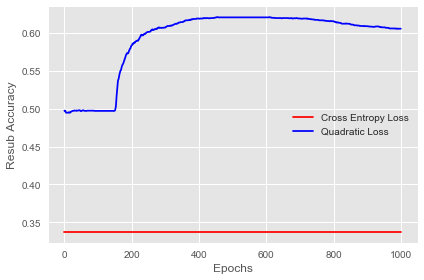

In [20]:
print_result(nn_cross_entropy,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quadratic,X_train,y_train,X_test,y_test,title="Quadratic Loss",color="blue")

plt.show()

The resubstitution accuracy for Cross Entropy Loss function is around 0.34. The resubstitution accuracy for Quadratic Loss function is 0.50 at the beginning and increase to 0.61 after the 160 iterations. The Quadratic Loss function shows a better resubstitution accuracy. 

#### 3.2.1.3 Number of layers

We create three models of layer 2, 3, and 8, separately. We use sigmoid as our phi function and quadratic as our loss function. 

In [21]:
params5 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 2, phi = 'sigmoid', f_cost = 'quadratic')
params6 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 3, phi = 'sigmoid', f_cost = 'quadratic')
params7 = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 8, phi = 'sigmoid', f_cost = 'quadratic')

In [22]:
%%time
params5['epochs'] = 200
params6['epochs'] = 200
params7['epochs'] = 200
nn_layer_2 = MLPLayerPerceptronBase(**params5)
nn_layer_3 = MLPLayerPerceptronBase(**params6)
nn_layer_8 = MLPLayerPerceptronBase(**params7)
nn_layer_2.fit(X_train, y_train, print_progress=50)
nn_layer_3.fit(X_train, y_train, print_progress=50)
nn_layer_8.fit(X_train, y_train, print_progress=50)

Epoch: 200/200

CPU times: user 25.6 s, sys: 2.15 s, total: 27.8 s
Wall time: 14.4 s


2 layers :
Resubstitution acc: 0.63903023047
Validation acc: 0.662679425837
3 layers :
Resubstitution acc: 0.624363962885
Validation acc: 0.626794258373
8 layers :
Resubstitution acc: 0.497156539958
Validation acc: 0.497607655502


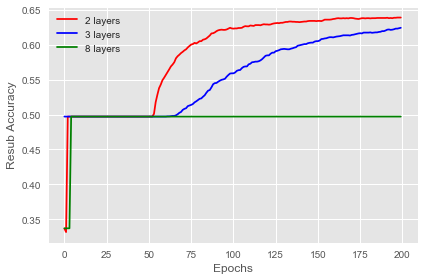

In [23]:
print_result(nn_layer_2,X_train,y_train,X_test,y_test,title="2 layers",color="red")
print_result(nn_layer_3,X_train,y_train,X_test,y_test,title="3 layers",color="blue")
print_result(nn_layer_8,X_train,y_train,X_test,y_test,title="8 layers",color="green")
plt.show()

The rank of resubstitution accuracy for modle of different layers are 2 layers> 3 layers > 8 layers.   
  Using f1 score as the metric(s) of evaluation, the best combination of phi function, loss function, and layers are sigmoid - Quadratic - 2 layers. 

### 3.2.2 Magnitude of the gradients

We build a 3-layer model and evaluate if the gradients in each layer of the neural network stay consistent.  

In [24]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 3, phi = 'sigmoid', f_cost = 'quadratic')

In [25]:
class MLPLayerGradients(MLPLayerPerceptronBase) :
    def __init__(self, n_hidden=30,           # n is number of nodes, not layer. still 2 layers. 
                 C=0.0, epochs=500, eta=0.001, random_state=None, layer = 2, phi = 'sigmoid', f_cost = 'quadratic'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.layer = layer
        self.phi = phi
        self.f_cost = f_cost
        #self.grad[i] = [None] * layer
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        # init weights and setup matrices
        #grad_w = [None] * self.layer
        #for i in range(self.layer):
        #    grad_w[i] = list()
        self.W = []
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A_list,Z_list = self._feedforward(X_data,self.W)
            
            cost = self._cost(A_list,Y_enc,self.W)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad_list = self._get_gradient(A_list, Z_list, Y_enc, self.W)

            self.W[0] -= self.eta * grad_list[0]
            self.W[len(self.W) - 1] -= self.eta * grad_list[len(self.W) - 1]
            for i in range(len(self.W)):
                self.W[i] -= self.eta * grad_list[i]
                grad[i].append(np.mean(grad_list[i]))
            self.score_.append(f1_score(y_data,self.predict(X_data),average='micro'))  
        for i in range(self.layer):
            grad[i]=np.array(grad[i])
            print(grad[i])
        return self

In [26]:
%%time
params['epochs']=20
grad = [None] * 3
for i in range(3):
    grad[i] = list()
nn_layer = MLPLayerGradients(**params)
nn_layer.fit(X_train, y_train, print_progress=50)

[-0.80835714 -0.47112514 -0.03784609  0.16527109  0.18190941  0.18694131
  0.19067235  0.19348296  0.19581849  0.19766026  0.19900484  0.19982719
  0.20010924  0.1998395   0.19901663  0.19765075  0.19576427  0.1933916
  0.19057809  0.18737804]
[ 0.16533588  0.2192954   0.05014131 -0.00843424 -0.01224273 -0.0129786
 -0.01304003 -0.0129281  -0.01274487 -0.01251227 -0.01223237 -0.01190302
 -0.01152093 -0.0110829  -0.01058635 -0.01002978 -0.00941303 -0.00873749
 -0.00800612 -0.00722334]
[  8.64348354e+00   3.19549826e+00   1.04229735e+00  -1.87698371e-03
  -6.29312187e-02  -6.65816783e-02  -6.33460990e-02  -5.87853721e-02
  -5.47811707e-02  -5.12999070e-02  -4.82475696e-02  -4.54985814e-02
  -4.29713513e-02  -4.06124494e-02  -3.83905495e-02  -3.62884533e-02
  -3.42979774e-02  -3.24161793e-02  -3.06427705e-02  -2.89783202e-02]
CPU times: user 563 ms, sys: 42.8 ms, total: 605 ms
Wall time: 313 ms


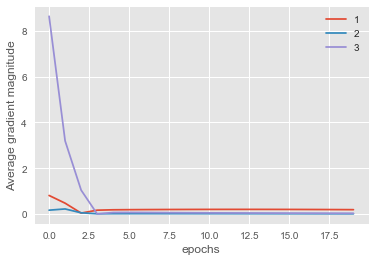

In [27]:
ax = plt.subplot(1,1,1)
for i in range(3):
    plt.plot(abs(grad[i]), label=i+1)
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('epochs')
plt.show()

The above plot shows the magnitude of the gradients in each layer of the neural network versus the training iteration. After about 3 iteration, the gradients stay consistent in each layer. 

# 4.Exceptional Work 

In [30]:
class MLPLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,           # 这里不是隐藏层数，而应该是隐藏的节点数，层数还是两层
                 C=0.0, epochs=500, eta=0.001, random_state=None, layer = 2, phi = 'sigmoid', f_cost = 'quadratic'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.layer = layer
        self.phi = phi
        self.f_cost = f_cost
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):                                      # 如果变成多层的话，这里需要增加
        """Initialize weights with small random numbers."""
        W = [None] * self.layer
        
        W_first_num_elems = (self.n_features_ + 1)*self.n_hidden
        W[0] = np.random.uniform(-1.0, 1.0, size = W_first_num_elems)
        W[0] = W[0].reshape(self.n_hidden, self.n_features_ + 1)
        
        W_last_num_elems = (self.n_hidden + 1)*self.n_output_
        W[self.layer - 1] = np.random.uniform(-1.0, 1.0, size = W_last_num_elems)
        W[self.layer - 1] = W[self.layer - 1].reshape(self.n_output_, self.n_hidden + 1)
        for i in range(1, self.layer - 1):
            W[i] = np.random.uniform(-1.0, 1.0, size=(self.n_hidden + 1)*self.n_hidden)
            W[i] = W[i].reshape(self.n_hidden, self.n_hidden + 1)
            
            
        return W
    
    @staticmethod
    def _sigmoid(z):    # 改成linear
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)        # 在这里进行替换
    
    def _linear(z):
        return z
    
    @staticmethod
    def _relu(z):                  
        return np.maximum(0,z.copy())
    
    @staticmethod              
    def _silu(z):
        return z*expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):                                          # 变成多层的话，这里需要增加
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        result = (lambda_/2.0) * np.sqrt(np.mean(W[0][:, 1:] ** 2))
        for i in range(1, len(W)):
            result = result + np.sqrt(np.mean(W[i][:, 1:] ** 2))
        return result
            
        #return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A_list,Y_enc,W):                                       # 变成多层的话，这里需要增加
        '''Get the objective function value'''
        if self.f_cost == 'quadratic':
            cost = np.mean((Y_enc-A_list[-1]**2))
        elif self.f_cost == 'cross_entropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_list[-1])+(1-Y_enc)*np.log(1-A_list[-1]))))
        L2_term = self._L2_reg(self.l2_C, W)        ################################!!!!!!!!!!!!
        return cost + L2_term                   ######################!!!!!!!!!!!!!!!!!1
        #return cost
                                      
    def _feedforward(self, X, W):
        """Compute feedforward step
        """
        A_list = [None] * (len(W) + 1)
        Z_list = [None] * len(W) 
        A = self._add_bias_unit(X, how='column')
        Z = W[0] @ A.T
        
        A_list[0] = A
        Z_list[0] = Z
        
        if self.phi == 'sigmoid':
            for i in range(1, len(W)):
                A_list[i] = self._sigmoid(Z_list[i - 1])
                A_list[i] = self._add_bias_unit(A_list[i], how='row')
                Z_list[i] = W[i] @ A_list[i]

            A_list[len(W)] = self._sigmoid(Z_list[len(W) - 1])                # A的个数要比W个数多1
        
        elif self.phi == 'linear':  #######################!!!!!!!!!!!!!!!!!!
            for i in range(1, len(W)):
                #A_list[i] = self._linear(Z_list[i - 1])
                A_list[i] = Z_list[i - 1]
                A_list[i] = self._add_bias_unit(A_list[i], how='row')
                Z_list[i] = W[i] @ A_list[i]

            #A_list[len(W)] = self._linear(Z_list[len(W) - 1])
            A_list[len(W)] = Z_list[len(W) - 1]
       
        elif self.phi == 'relu':
            for i in range(1, len(W)):
                A_list[i] = self._relu(Z_list[i - 1])
                A_list[i] = self._add_bias_unit(A_list[i], how='row')
                Z_list[i] = W[i] @ A_list[i]
            
            A_list[len(W)] = self._relu(Z_list[len(W) - 1])
        
        elif self.phi == 'silu':
            for i in range(1, len(W)):
                A_list[i] = self._silu(Z_list[i-1])
                A_list[i] = self._add_bias_unit(A_list[i], how='row')
                Z_list[i] = W[i] @ A_list[i]
            
            A_list[len(W)] = self._silu(Z_list[len(W) - 1])
            
        return A_list, Z_list
        
    def _get_gradient(self, A_list, Z_list, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        sigma = [None] * len(W)
        if self.f_cost == 'quadratic':
            sigma[-1] = -2 * (Y_enc - A_list[-1]) * (A_list[-1]) * (1 - A_list[-1])
        elif self.f_cost == 'cross_entropy':
            sigma[-1] = (A_list[-1] - Y_enc)
        if self.phi == 'sigmoid':
            sigma[-2] = (W[-1].T @ sigma[-1]) * A_list[-2] * (1 - A_list[-2])
            for i in range(len(sigma) - 3, -1, -1):
                sigma[i] = (W[i + 1].T @ sigma[i + 1][1:,:]) * A_list[i + 1] * (1 - A_list[i + 1])
        
        elif self.phi == 'linear':
            sigma[-2] = (W[-1].T @ sigma[-1])
            for i in range(len(sigma) - 3, -1, -1):
                sigma[i] = (W[i + 1].T @ sigma[i + 1][1:,:])
        
        elif self.phi == 'relu': 
            sigma[-2] = (W[-1].T @ sigma[-1])
            for i in range(len(sigma) - 3, -1, -1):
                sigma[i] = (W[i + 1].T @ sigma[i + 1][1:,:])

        elif self.f_hidden == 'silu':
            sigma[-2] =(self.grad_forward(self.A[-2]))
            for i in range(len(sigma) - 3, -1, -1):
                sigma[i] = (W[i + 1].T @ sigma[i + 1][1:,:]) * A_list[i + 1] * (1 - A_list[i + 1])
        
        #sigma[0] = (W[1].T @ sigma[1][1:, :]) * A_list[1] * (1- A_list[1])
        #sigma[1] = (W[1].T @ sigma[2][1:, :]) * A_list[2] * (1- A_list[2])
        #sigma[0] = (W[1].T @ sigma[1][1:, :]) * A_list[1] * (1- A_list[1]) ############################
        grad_list = [None] * (self.layer)         # grad的数目是小1个的
        grad_list[0] = sigma[0][1:,:] @ A_list[0]
        grad_list[len(grad_list) - 1] = sigma[len(grad_list) - 1] @ A_list[len(grad_list) - 1].T
        for i in range(1, len(grad_list) - 1):
            grad_list[i] = sigma[i][1:, :] @ A_list[i].T
        for i in range(len(grad_list)):             #######################!!!!!!!!!!!!!!!!!!!!!
            grad_list[i][:, 1:] = W[i][:,1:] * self.l2_C
        return grad_list
        
    
    def predict(self, X):
        """Predict class labels"""
        A_list,Z_list = self._feedforward(X, self.W)
        y_pred = np.argmax(A_list[-1], axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.W = []
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A_list,Z_list = self._feedforward(X_data,self.W)
            
            cost = self._cost(A_list,Y_enc,self.W)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad_list = self._get_gradient(A_list, Z_list, Y_enc, self.W)

            self.W[0] -= self.eta * grad_list[0]
            self.W[len(self.W) - 1] -= self.eta * grad_list[len(self.W) - 1]
            for i in range(len(self.W)):
                self.W[i] -= self.eta * grad_list[i]
            

        return self

In [31]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 5, phi = 'relu', f_cost = 'cross_entropy')

In [32]:
%%time
params['epochs'] = 1000
nn = MLPLayerPerceptronBase(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 1000/1000

Accuracy: 0.336124401914
CPU times: user 18.8 s, sys: 3.14 s, total: 21.9 s
Wall time: 11.7 s


In [33]:
params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=0.001,  # learning rate
              random_state=1, layer = 5, phi = 'silu', f_cost = 'cross_entropy')

In [34]:
%%time
params['epochs'] = 1000
nn = MLPLayerPerceptronBase(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 1000/1000

Accuracy: 0.355263157895
CPU times: user 52.9 s, sys: 5.07 s, total: 58 s
Wall time: 30.4 s


From above, we can see that when layer = 5, the accuracy of silu is highest, relu is lowest.

Relu is one of the most popular activate functions because the speed is fast, which reduces many computation.However, it's easy to die.

Silu is one new method, and it has higher accuracy and costs more. 

# Reference

https://github.com/eclarson/MachineLearningNotebooks